In [214]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.coordinates import SkyCoord

In [215]:
# Age option 3 APOKASC-3 Pinsonneault et al. 2025
#Reading in the table, making sure all the tables have a column named Age in Gyr
# and that every star in the table has an Age
apokasc3raw= Table.read("Pinsonneault2025.txt", format="ascii.cds")
#in this case there were two age columns, one for Red Clump and one for Red Giant Branch so we combine them
ageRC=np.array(apokasc3raw['AgeRC']*(apokasc3raw['EvolState']=='RC'))
rcnans=np.isnan(ageRC) #removing nans from this version of the table.
ageRC[rcnans]=0
ageRGB=np.array(apokasc3raw['AgeRGB']*(apokasc3raw['EvolState']=='RGB'))
rgbnans=np.isnan(ageRGB) #removing nans from this version of the table.
ageRGB[rgbnans]=0
apokasc3raw['Age']=(ageRC+ageRGB)

hasagea3=np.where((apokasc3raw['Age']==apokasc3raw['Age']) & (apokasc3raw['Age']>0.1))
apokasc3=apokasc3raw[hasagea3]
apokasc3

KIC,EvolState,ESSource,CatTab,SeisSource,SpecSource,NNumax,NDNu,Nquar,Numax,e_Numax,DNu,e_DNu,FDNu,e_FDNu,FNumax,Mass,e_Mass,Radius,e_Radius,logg-Seis,e_logg-Seis,Teff,e_Teff,logg-Spec,e_logg-Spec,[Fe/H],e_[Fe/H],[a/Fe],e_[a/Fe],[C/Fe],e_[C/Fe],[N/Fe],e_[N/Fe],InvRGaia,e_InvRGaia,AgeCat,AgeRGB,E_AgeRGB,e_AgeRGB,AgeRC,E_AgeRC,e_AgeRC,vsini,alphaCat,GaiaDR3,2MASS,Age
,,,,,,,,,uHz,uHz,uHz,uHz,,,,Msun,Msun,Rsun,Rsun,dex(cm / s2),dex(cm / s2),K,K,dex(cm / s2),dex(cm / s2),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),,,,Gyr,Gyr,Gyr,Gyr,Gyr,Gyr,km / s,,,,
int64,str7,str4,str8,str4,str4,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,str5,int64,str23,float64
893214,RGB,Seis,Gold,WAvg,DR17,8,5,15,40.5841,0.2874,4.3254,0.0289,1.0277,0.005,0.9976,1.4404,0.0602,11.0014,0.2055,2.5146,0.0042,4718.9233,44.7811,2.4559,0.058,-0.2617,0.058,0.0815,0.022,-0.0626,0.0135,0.2483,0.0164,0.082389,0.002866,RGB,2.8815,0.298,-0.2639,2.8815,0.298,-0.2639,0.0,Apoor,2050237616959273728,2MASS J19245967+3638183,2.8815
1026180,RC,Spec,Gold,WAvg,DR17,8,5,4,35.6089,0.2338,3.9208,0.0265,0.9972,0.005,0.9936,1.5334,0.0633,12.2361,0.2278,2.4512,0.0039,4576.1016,40.5161,2.4066,0.058,0.2741,0.058,0.0215,0.022,0.0568,0.0084,0.3647,0.0107,0.085599,0.002161,RC,--,--,--,3.1325,0.2754,-0.1905,0.0,Apoor,2050237174589477888,2MASS J19241923+3645378,3.1325
1026309,RGB,Seis,Silver,WAvg,DR17,8,4,18,16.6974,0.5675,1.9432,0.0805,1.0072,0.005,1.0205,2.642,0.518,23.2678,2.0993,2.1176,0.0148,4479.2246,39.7068,2.2388,0.058,0.1609,0.058,-0.0295,0.022,-0.0823,0.0088,0.2913,0.011,0.047943,0.001239,RGB_AGB,0.5842,0.1481,-0.109,0.7082,0.1832,-0.1405,0.0,Apoor,2050236934071312384,2MASS J19242636+3643594,0.5842
1026452,RC,Seis,Gold,WAvg,DR17,8,5,18,34.3652,0.2256,3.9749,0.0268,0.9953,0.005,0.9936,1.4618,0.0599,11.9485,0.2215,2.451,0.0044,4910.6035,53.0693,2.4907,0.058,-0.2652,0.058,0.0658,0.022,0.0005,0.0189,0.1605,0.0222,0.075937,0.003795,RC,--,--,--,2.6495,0.2319,-0.1919,0.0,Apoor,2050243050104808960,2MASS J19243452+3647244,2.6495
1027110,RGB,Seis,Silver,WAvg,DR17,8,4,18,6.5198,0.1616,1.1613,0.044,1.0511,0.005,1.0535,1.0367,0.1769,23.337,1.8791,1.6949,0.011,4194.4375,37.9582,1.7495,0.058,-0.3017,0.058,0.2615,0.022,0.1451,0.0109,0.1366,0.0131,0.040245,0.001509,RGB_AGB,9.0694,8.0551,-3.8133,7.2088,4.6171,-2.3475,0.0,Arich,2050239201814200192,2MASS J19250937+3644599,9.0694
1027337,RGB,Seis,Gold,WAvg,DR17,9,6,18,74.3689,0.4491,6.9661,0.0418,1.0282,0.005,0.9959,1.2676,0.0489,7.6702,0.133,2.7732,0.0038,4621.996,41.3674,2.7836,0.058,0.2081,0.058,0.0354,0.022,0.062,0.009,0.2898,0.0115,0.123008,0.0033,RGB,5.8519,0.5953,-0.5247,5.8519,0.5953,-0.5247,0.0,Apoor,2050240782362231552,2MASS J19252021+3647118,5.8519
1027707,RGB,Seis,Silver,WAvg,DR17,6,3,18,3.0206,0.0885,0.5593,0.0309,1.0265,0.005,1.0663,2.0033,0.4792,48.0566,5.5208,1.3484,0.0129,3961.365,35.9864,1.4062,0.058,0.1105,0.058,0.0356,0.022,0.0455,0.0079,0.1751,0.0094,0.018104,0.001509,RGB_AGB,1.3052,0.6198,-0.3779,1.5494,0.4593,-0.4138,0.0,Apoor,2050240129527252096,2MASS J19253846+3646103,1.3052
1160655,RGB,Seis,Silver,WAvg,DR17,5,2,18,1.5726,0.0502,0.3698,0.024,1.0608,0.005,1.0525,1.1903,0.3305,52.0838,6.9807,1.058,0.0139,3837.788,33.9314,0.9088,0.058,-0.1446,0.058,0.1098,0.022,0.0582,0.0089,0.2023,0.0105,0.018767,0.001236,RGB_AGB,5.7073,8.7454,-2.777,5.013,5.3362,-2.0267,0.0,Arich,2050252395953454464,2MASS J19232193+3650379,5.7073


In [216]:
#Pick from any of the previous 4 options
agedata= apokasc3

In [217]:
print('Answer: There are '+str(len(agedata))+' targets with ages in agedata.')

Answer: There are 12291 targets with ages in agedata.


In [218]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

In [219]:
filename='astraAllStarASPCAP-0.6.0.fits'
tb = fits.open(filename)
data = tb[2].data

In [220]:
mask_gaia = (data['zgr_plx']>0)

In [221]:
data_masked=data[mask_gaia]
good = np.where(
    (data_masked['teff'] > 3700) & (data_masked['teff'] < 5300) &
    (data_masked['logg'] > 0.9) & (data_masked['logg'] < 3.3) &
    (data_masked['m_h_atm'] > -2.0) & (data_masked['m_h_atm'] < 0.6) &
    (data_masked['flag_bad'] == False)
)

data_cut = data_masked[good]

In [222]:
apok3_gaia = apokasc3['GaiaDR3']
dr19_gaia = data_cut['gaia_dr3_source_id']
print(apok3_gaia[:5])
print(dr19_gaia[:5])

      GaiaDR3      
-------------------
2050237616959273728
2050237174589477888
2050236934071312384
2050243050104808960
2050239201814200192
[4184200643505162112 4184125807991900928 4184137077986034048
 4183930438518525184 4689447878791422208]


In [223]:
lookup = {dr19_gaia[i]: i for i in range(len(dr19_gaia))}

In [224]:
#Option 3 APOKASC-3 Pinsonneault et al. 2025
intersect, ind_a, ind_b = np.intersect1d(data_cut['gaia_dr3_source_id'], agedata['GaiaDR3'], return_indices=True)

In [225]:
matched_apok3_rows = []
matched_dr19_indices = []
for row in apokasc3:
    gid = row['GaiaDR3']
    if gid is None or np.isnan(gid):
        continue
    if gid in lookup:
        matched_apok3_rows.append(row)
        matched_dr19_indices.append(lookup[gid])

In [226]:
apokasc3_matched = Table(rows=matched_apok3_rows, names=apokasc3.colnames)
idx = np.array(matched_dr19_indices)

In [227]:
print("Matched APOKASC-3 stars:", len(apokasc3_matched))

Matched APOKASC-3 stars: 11028


In [228]:
fullx = np.dstack([data_cut['teff'][idx], data_cut['logg'][idx], data_cut['m_h_atm'][idx],
    data_cut['alpha_m_atm'][idx], data_cut['c_h'][idx], data_cut['n_h'][idx]])[0]

fully = np.dstack([apokasc3_matched['Age']])[0] #for APOKASC-3 seismic ages

#remove non-finite entries!
mask = np.all(np.isfinite(fullx), axis=1) & np.all(np.isfinite(fully), axis=1)
fullx, fully = fullx[mask], fully[mask]

scaling_x = np.median(fullx, axis=0)
scaling_y = np.median(fully, axis=0)

fullx = fullx / scaling_x
fully = fully / scaling_y
apok3_ids = apokasc3_matched['KIC']

In [229]:
tenpercent = len(fully) // 10

trainbin = slice(0, -1*tenpercent-1)
testing  = slice(-1*tenpercent, -1)

x_train, y_train = fullx[trainbin], fully[trainbin]
x_test,  y_test  = fullx[testing], fully[testing]

# Model A

In [231]:
neurons_per_layer_A = 32
layers_A = 10
iterations_A = 150

In [232]:
inputs = keras.Input(shape=(6,))
x = inputs
for i in range(layers_A):
    x = keras.layers.Dense(neurons_per_layer_A, activation='relu')(x)

outputs_A = keras.layers.Dense(1)(x)
modelA = keras.Model(inputs=inputs, outputs=outputs_A)
modelA.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,761 (38.13 KB)

 Trainable params: 9,761 (38.13 KB)

 Non-trainable params: 0 (0.00 B)

In [233]:
modelA.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [234]:
modelA.fit(x_train, y_train, epochs=iterations_A, validation_data=(x_test, y_test), batch_size=300)

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 1.0449 - val_accuracy: 0.0000e+00 - val_loss: 0.6994
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6880 - val_accuracy: 0.0000e+00 - val_loss: 0.5749
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6076 - val_accuracy: 0.0000e+00 - val_loss: 0.5068
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5677 - val_accuracy: 0.0000e+00 - val_loss: 0.5558
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5777 - val_accuracy: 0.0000e+00 - val_loss: 0.4892
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5512 - val_accuracy: 0.0000e+00 - val_loss: 0.4835
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5525 - val_accuracy: 0.0000e+00 - val_loss: 0.4799
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - ac

In [235]:
predictionsA = modelA.predict(x_test)
ages_A = predictionsA.flatten() * scaling_y
print("Model A predictions:", len(ages_A))
print("Test set size:", len(y_test))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model A predictions: 1033
Test set size: 1033


In [236]:
print("Training set size:", len(x_train))
print("Test set size:", len(x_test))

Training set size: 9311
Test set size: 1033


In [237]:
metric = 0.3

goodfitA = np.where(((1 - metric) < predictionsA / y_test) & ((1 + metric) > predictionsA / y_test))
badfitA  = np.where(((1 - metric) > predictionsA / y_test) | ((1 + metric) < predictionsA / y_test))

print('With', neurons_per_layer_A, 'neurons per layer,', layers_A, 'layers, and', iterations_A, 'iterations')
print('using the training set', trainbin)
print(len(goodfitA[0]) / len(y_test) * 100, 'percent of the ages are good')
print(len(badfitA[0]) / len(y_test) * 100,  'percent of the ages are bad')

With 32 neurons per layer, 10 layers, and 150 iterations
using the training set slice(0, -1035, None)
66.60212971926428 percent of the ages are good
33.39787028073572 percent of the ages are bad


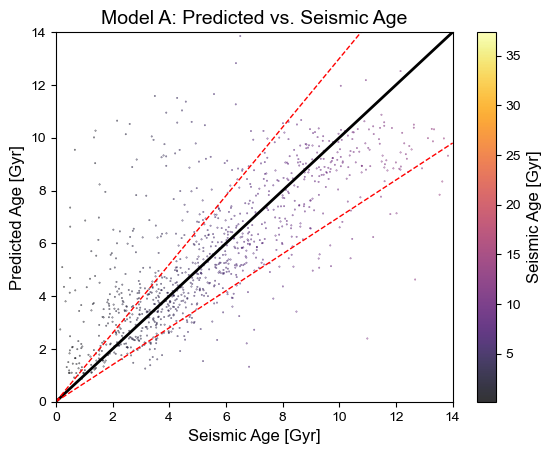

In [238]:
plt.scatter(y_test.flatten() * scaling_y, predictionsA.flatten() * scaling_y, 
    s=0.1, c=(y_test.flatten() * scaling_y), cmap='inferno', alpha=0.8)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.plot([0, 14], [0, 14], 'k-', linewidth=2)
plt.plot([0, 14], [0, 14 * (1 + metric)], 'r--', linewidth=1)
plt.plot([0, 14], [0, 14 * (1 - metric)], 'r--', linewidth=1)
plt.xlabel('Seismic Age [Gyr]')
plt.ylabel('Predicted Age [Gyr]')
plt.title('Model A: Predicted vs. Seismic Age')
cbar = plt.colorbar()
cbar.set_label('Seismic Age [Gyr]')
plt.savefig("Task_12_ModelA_Predicted_vs_SeismicAge_ALL_Donley.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Model B

In [240]:
neurons_per_layer_B = 64
layers_B = 5
iterations_B = 120

In [241]:
inputs = keras.Input(shape=(6,))
x = inputs
for i in range(layers_B):
    x = keras.layers.Dense(neurons_per_layer_B, activation='relu')(x)

outputs_B = keras.layers.Dense(1)(x)
modelB = keras.Model(inputs=inputs, outputs=outputs_B, name='modelB')
modelB.summary()

Model: "modelB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,153 (67.00 KB)

 Trainable params: 17,153 (67.00 KB)

 Non-trainable params: 0 (0.00 B)

In [242]:
modelB.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [243]:
x_train_B = x_train
y_train_B = y_train
x_test_B = x_test
y_test_B = y_test

In [244]:
modelB.fit(x_train_B, y_train_B, epochs=iterations_B, batch_size=300, validation_data=(x_test_B, y_test_B))

Epoch 1/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 0.8919 - val_accuracy: 0.0000e+00 - val_loss: 0.6291
Epoch 2/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6192 - val_accuracy: 0.0000e+00 - val_loss: 0.5011
Epoch 3/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5679 - val_accuracy: 0.0000e+00 - val_loss: 0.4854
Epoch 4/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5605 - val_accuracy: 0.0000e+00 - val_loss: 0.4936
Epoch 5/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5616 - val_accuracy: 0.0000e+00 - val_loss: 0.5063
Epoch 6/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5575 - val_accuracy: 0.0000e+00 - val_loss: 0.4914
Epoch 7/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5474 - val_accuracy: 0.0000e+00 - val_loss: 0.4730
Epoch 8/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

In [245]:
predictionsB = modelB.predict(x_test_B)
predictionsB = predictionsB.flatten()
trueB = y_test_B.flatten()
print(len(predictionsB))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1033


In [246]:
metric = 0.3

goodfitB = np.where( ((1 - metric) < predictionsB / trueB) & ((1 + metric) > predictionsB / trueB) )
badfitB  = np.where( ((1 - metric) > predictionsB / trueB) | ((1 + metric) < predictionsB / trueB) )

print('With', neurons_per_layer_B, 'neurons per layer,', layers_B, 'layers, and', iterations_B, 'iterations')
print('using the training set', trainbin)
print(len(goodfitB[0]) / len(trueB) * 100, 'percent of the ages are good')
print(len(badfitB[0]) / len(trueB) * 100, 'percent of the ages are bad')

With 64 neurons per layer, 5 layers, and 120 iterations
using the training set slice(0, -1035, None)
66.02129719264279 percent of the ages are good
33.978702807357216 percent of the ages are bad


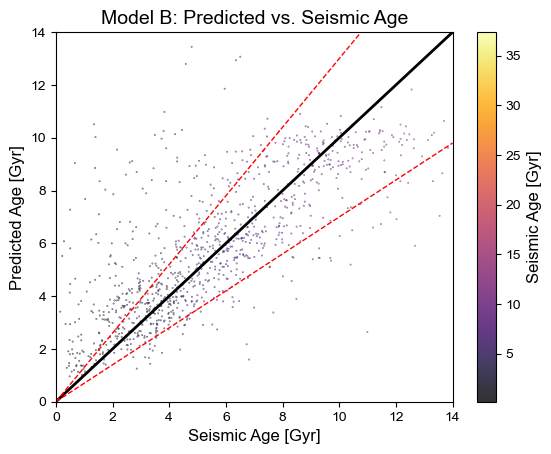

In [247]:
plt.scatter(trueB * scaling_y, predictionsB.flatten() * scaling_y, 
    s=0.1, c=(trueB * scaling_y), cmap='inferno', alpha=0.8)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.plot([0, 14], [0, 14], 'k-', linewidth=2)
plt.plot([0, 14], [0, 14 * (1 + metric)], 'r--', linewidth=1)
plt.plot([0, 14], [0, 14 * (1 - metric)], 'r--', linewidth=1)
plt.xlabel('Seismic Age [Gyr]')
plt.ylabel('Predicted Age [Gyr]')
plt.title('Model B: Predicted vs. Seismic Age')
cbar = plt.colorbar()
cbar.set_label('Seismic Age [Gyr]')
plt.savefig("Task_12_ModelB_Predicted_vs_SeismicAge_ALL_Donley.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [248]:
print("Model A ages min/max:", predictionsA.min(), predictionsA.max())
print("Model B ages min/max:", predictionsB.min(), predictionsB.max())

Model A ages min/max: 0.17486826 4.807913
Model B ages min/max: 0.19229695 6.7587934


In [249]:
print("Model A ages min/max:",
      (predictionsA.flatten() * scaling_y).min(),
      (predictionsA.flatten() * scaling_y).max())

print("Model B ages min/max:",
      (predictionsB.flatten() * scaling_y).min(),
      (predictionsB.flatten() * scaling_y).max())

Model A ages min/max: 0.8716920251920819 23.966724253368376
Model B ages min/max: 0.9585714612230658 33.6915710508585


In [250]:
test_ids = apokasc3_matched['KIC'][testing]
print("Number of KIC IDs set:", len(test_ids))

Number of KIC IDs set: 1033


In [251]:
true_age = y_test.flatten() * scaling_y
ageA = predictionsA.flatten() * scaling_y
ageB = predictionsB.flatten() * scaling_y 

In [252]:
print(len(test_ids), len(true_age), len(ageA), len(ageB))

1033 1033 1033 1033


In [253]:
import pandas as pd
results_table = pd.DataFrame({
    'KIC': test_ids,
    'Seismic_Age_Gyr': true_age,
    'Pred_Age_A_Gyr': ageA,
    'Pred_Age_B_Gyr': ageB,
    'Difference_B_minus_A': ageB - ageA})
print("Results table size:", len(results_table))
results_table.head()

Results table size: 1033


,KIC,Seismic_Age_Gyr,Pred_Age_A_Gyr,Pred_Age_B_Gyr,Difference_B_minus_A
0,11403437,12.3847,9.203126,9.911847,0.708720
1,11403541,4.3850,1.919929,1.976728,0.056799
2,11403918,5.4317,5.602170,5.875329,0.273160
3,11404916,7.3456,5.198683,5.913728,0.715045
4,11404925,0.9791,3.028524,1.884917,-1.143608


In [254]:
diff = results_table['Difference_B_minus_A']
mean_diff = np.mean(diff)
mean_abs_diff = np.mean(np.abs(diff))
rms_diff = np.sqrt(np.mean(diff**2))
print("Mean difference (B - A):", mean_diff)
print("Mean absolute difference:", mean_abs_diff)
print("RMS difference:", rms_diff)

Mean difference (B - A): 0.1732135296979297
Mean absolute difference: 0.4918900695354128
RMS difference: 0.7581341254984061


In [255]:
results_table.to_csv("Task_12_APOKASC3_Age_Comparison_Donley.csv", index=False)
print("Saved file: Task_12_APOKASC3_Age_Comparison_Donley.csv")

Saved file: Task_12_APOKASC3_Age_Comparison_Donley.csv


In [256]:
std_diff = np.std(diff)
print("Average difference (B - A):", avg_diff)
print("Standard deviation:", std_diff)

Average difference (B - A): 0.5943736807590078
Standard deviation: 0.738081584497823


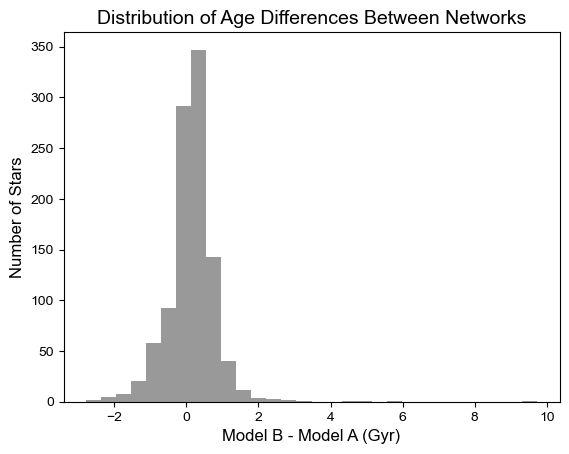

In [257]:
plt.hist(results_table['Difference_B_minus_A'], bins=30, color='grey', alpha=0.8)
plt.xlabel("Model B - Model A (Gyr)")
plt.ylabel("Number of Stars")
plt.title("Distribution of Age Differences Between Networks")
plt.savefig("Task_12_AgeDifference_Distribution_Donley.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()